In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import argparse
import sys
import os
import random
import librosa
import numpy as np
sys.path.append('../')
from src.information_encoder.samplers import PerfectBatchSampler
from src.information_encoder.losses import AngleProtoLoss
from benchmark import utils
import logging
import time
from tqdm import tqdm
from src.losses import loss
from torch.utils.data import WeightedRandomSampler
from transformers import AutoModel
from torch import nn
import torch.nn.functional as F
from benchmark.utils.dataset.dataset import fixed_timbre_perturb
import torchaudio.transforms as T

import math
from torch.optim.lr_scheduler import _LRScheduler

In [21]:
class GenderRepresentationModel(nn.Module):
    def __init__(self, input_dim=80, hidden_dim=512, num_categories=8, num_attention_heads=4):
        super().__init__()

        # Initial dropout for input features
        self.wav_dropout = nn.Dropout(0.5)

        # Linear projection to hidden dimension
        self.wav_proj = nn.Linear(input_dim, hidden_dim)

        # Multi-head attention layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_attention_heads,
            dropout=0.5,
            batch_first=True
        )
        self.attn_norm = nn.LayerNorm(hidden_dim)

        # Convolutional layer
        self.conv1d = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.conv_norm = nn.LayerNorm(hidden_dim)

        # Attention pooling layer
        self.attn_pooling = nn.Linear(hidden_dim, 1)

    def forward(self, wavlm_output):
        # Apply initial dropout to inputs
        wav_x = self.wav_dropout(wavlm_output)

        # Project to hidden dimension
        wav_x = self.wav_proj(wav_x)

        # Process with multi-head attention
        attn_output, _ = self.multihead_attn(wav_x, wav_x, wav_x)
        wav_x = self.attn_norm(attn_output + wav_x)  # Residual connection with layer norm

        # Convolutional processing
        wav_x = wav_x.transpose(1, 2)  # Change to (batch_size, hidden_dim, seq_len) for Conv1D
        conv_x = self.conv1d(wav_x)
        conv_x = self.conv_norm(conv_x.transpose(1, 2))  # Back to (batch_size, seq_len, hidden_dim) after LayerNorm

        # Attention pooling
        attn_weights = F.softmax(self.attn_pooling(conv_x), dim=1)  # Shape: (batch_size, seq_len, 1)
        embeddings = torch.sum(conv_x * attn_weights, dim=1)  # Weighted sum over sequence length

        return embeddings

class BidirectionalReferenceEncoder(nn.Module):
    """NN module creating a fixed size prosody embedding from a spectrogram.

    inputs: mel spectrograms [batch_size, num_spec_frames, num_mel]
    outputs: [batch_size, embedding_dim]
    """

    def __init__(self, num_mel, embedding_dim, use_nonlinear_proj = False):

        super().__init__()
        self.num_mel = num_mel
        self.embedding_dim = embedding_dim
        filters = [1] + [32, 32, 64, 64, 128, 128]
        num_layers = len(filters) - 1
        convs = [
            nn.Conv2d(
                in_channels=filters[i], out_channels=filters[i + 1], kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
            )
            for i in range(num_layers)
        ]
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList([nn.BatchNorm2d(num_features=filter_size) for filter_size in filters[1:]])

        post_conv_height = self.calculate_post_conv_height(num_mel, 3, 2, 1, num_layers)
        self.recurrence = nn.GRU(
            input_size=filters[-1] * post_conv_height, hidden_size=embedding_dim//2, batch_first=True, bidirectional=True
        )
        self.dropout = nn.Dropout(p=0.5)
    
        self.use_nonlinear_proj = use_nonlinear_proj

        if(self.use_nonlinear_proj):
            self.proj = nn.Linear(embedding_dim, embedding_dim)
            nn.init.xavier_normal_(self.proj.weight) # Good init for projection
            # self.proj.bias.data.zero_() # Not random bias to "move" z

    def forward(self, inputs):
        batch_size = inputs.size(0)
        # x = inputs.view(batch_size, 1, -1, self.num_mel)
        x = inputs.unsqueeze(1)
        # x: 4D tensor [batch_size, num_channels==1, num_frames, num_mel]
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x)
            x = bn(x)
            x = F.relu(x)

        x = x.transpose(1, 2)
        # x: 4D tensor [batch_size, post_conv_width,
        #               num_channels==128, post_conv_height]
        post_conv_width = x.size(1)
        x = x.contiguous().view(batch_size, post_conv_width, -1)
        # x: 3D tensor [batch_size, post_conv_width,
        #               num_channels*post_conv_height]

        self.recurrence.flatten_parameters()
        _, out = self.recurrence(x)
        # out: 3D tensor [seq_len==2, batch_size, encoding_size=384]
        out = torch.cat([out[0,:,:], out[1,:,:]], dim = 1)
        # out: 2D tensor [batch_size, encoding_size = 384]

        # print(out.shape)
        if(self.use_nonlinear_proj):
            out = torch.tanh(self.proj(out))
            out = self.dropout(out)
            
        return out

    @staticmethod
    def calculate_post_conv_height(height, kernel_size, stride, pad, n_convs):
        """Height of spec after n convolutions with fixed kernel/stride/pad."""
        for _ in range(n_convs):
            height = (height - kernel_size + 2 * pad) // stride + 1
        return height

In [22]:
class MultiLabelAudioDataset(Dataset):
    def __init__(self, wav_files, audio_dir):
        self.wav_paths = wav_files
        # self.labels = labels
        self.lazy_path = audio_dir
        
    def __len__(self):
        return len(self.wav_paths)


    def __getitem__(self, idx):
        # label = self.labels[idx]
        # feat = torch.load(feat_name)
        utter = self.wav_paths[idx]
        feat_name = os.path.join(self.lazy_path, self.wav_paths[idx].replace('.wav','.pt'))
        feat = torch.load(feat_name, map_location='cpu')
        return {
            "feat": feat,
            "utter": utter,  # Use float for BCEWithLogitsLoss
        }

In [23]:
df = pd.read_csv("../benchmark/processed_labels.csv")

In [24]:
df_val = df[df['Split_Set'] == 'Development']
df_val.head(2)

,FileName,Angry,Sad,Happy,Surprise,Fear,Disgust,Contempt,Neutral,Split_Set
0,MSP-PODCAST_0002_0033.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Development
1,MSP-PODCAST_0002_0039.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Development


In [25]:
dataset = MultiLabelAudioDataset(df_val.FileName.values.tolist(), '/workspace/lucas.ueda/interspeech_ser/data_tmp/wavlm_large')

In [26]:
dataset.wav_paths[4]

'MSP-PODCAST_0006_0017.wav'

In [27]:
dataset.__getitem__(3)

{'feat': tensor([[ 0.0104,  0.1546, -0.2043,  ..., -0.4211,  0.4074, -0.2074],
         [-0.0618,  0.1313, -0.1846,  ..., -0.1376,  0.1368, -0.1451],
         [-0.1910,  0.1318, -0.0410,  ..., -0.1359, -0.1206,  0.0122],
         ...,
         [-0.2868,  0.3348,  0.3625,  ...,  0.0288,  0.2623, -0.1730],
         [-0.1333,  0.2430,  0.4265,  ...,  0.0717,  0.1680,  0.1287],
         [-0.2690,  0.1238,  0.3299,  ..., -0.0193,  0.3853,  0.0598]]),
 'utter': 'MSP-PODCAST_0002_0061.wav'}

In [28]:
loader = DataLoader(dataset, batch_size=1, shuffle=False)


In [29]:
batch = next(iter(loader))

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ser_model = GenderRepresentationModel(input_dim=1024, hidden_dim=512, num_categories=2, num_attention_heads=4)


In [33]:
ser_model.load_state_dict(torch.load('../experiments/ownsermodel_wavlmlarge_lazyload_lr1e4_angleloss_gender/angle_gender.pt', map_location='cpu'))
ser_model.to('cpu')

GenderRepresentationModel(
  (wav_dropout): Dropout(p=0.5, inplace=False)
  (wav_proj): Linear(in_features=1024, out_features=512, bias=True)
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (attn_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (conv1d): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (attn_pooling): Linear(in_features=512, out_features=1, bias=True)
)

In [34]:
emb = ser_model(batch['feat'].to('cpu'))

In [35]:
emb.shape

torch.Size([1, 512])

In [36]:
features = []
utts = []

for batch in tqdm(loader):
    emb = ser_model(batch['feat']).squeeze(0).detach().numpy()
    features.append(emb)
    utts.append(batch['utter'])

features = np.array(features)


00%|████████████████████████████████████████████████████████████████████████████| 25258/25258 [04:01<00:00, 104.51it/s]

In [37]:
!pip install umap-learn

In [38]:
import umap

In [39]:
reducer = umap.UMAP(random_state = 42)

embeddings = reducer.fit_transform(features)

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [40]:
df_p = pd.DataFrame({'FileName': [utt[0] for utt in utts], 'dim1': embeddings[:,0], 'dim2': embeddings[:,1]})
df_p.head()

,FileName,dim1,dim2
0,MSP-PODCAST_0002_0033.wav,-2.799032,0.796687
1,MSP-PODCAST_0002_0039.wav,-2.436559,1.773111
2,MSP-PODCAST_0002_0051.wav,-0.600959,-3.332659
3,MSP-PODCAST_0002_0061.wav,-2.612125,5.585777
4,MSP-PODCAST_0006_0017.wav,-2.068648,-2.669755


In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
df = pd.read_csv('/workspace/lucas.ueda/interspeech_ser/data/Labels/labels_consensus.csv')
df_p = df_p.merge(df[['FileName','Gender']], how='left', on = 'FileName')

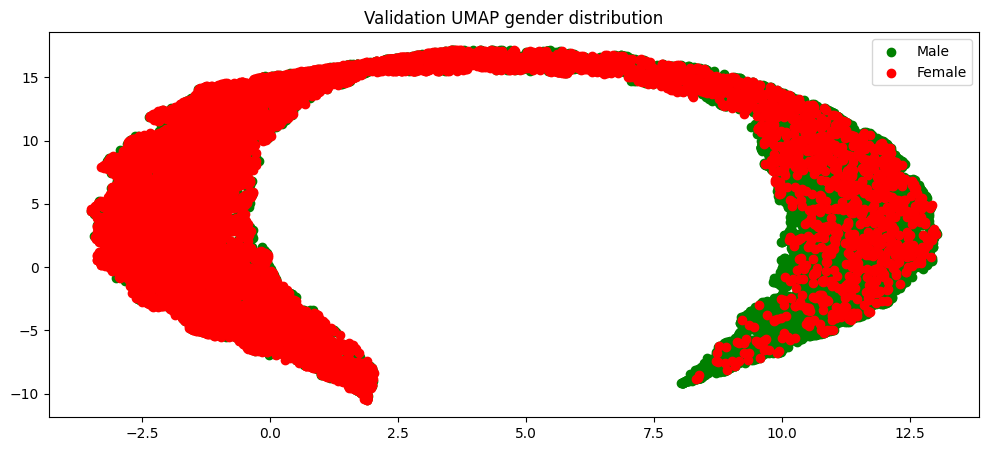

In [47]:
plt.figure(figsize=(12,5))
plt.title('Validation UMAP gender distribution')
plt.scatter(df_p[df_p['Gender'] == 'Male']['dim1'], df_p[df_p['Gender'] == 'Male']['dim2'], label = 'Male', color='green')
plt.scatter(df_p[df_p['Gender'] == 'Female']['dim1'], df_p[df_p['Gender'] == 'Female']['dim2'], label = 'Female', color='red')

plt.legend()
plt.show()

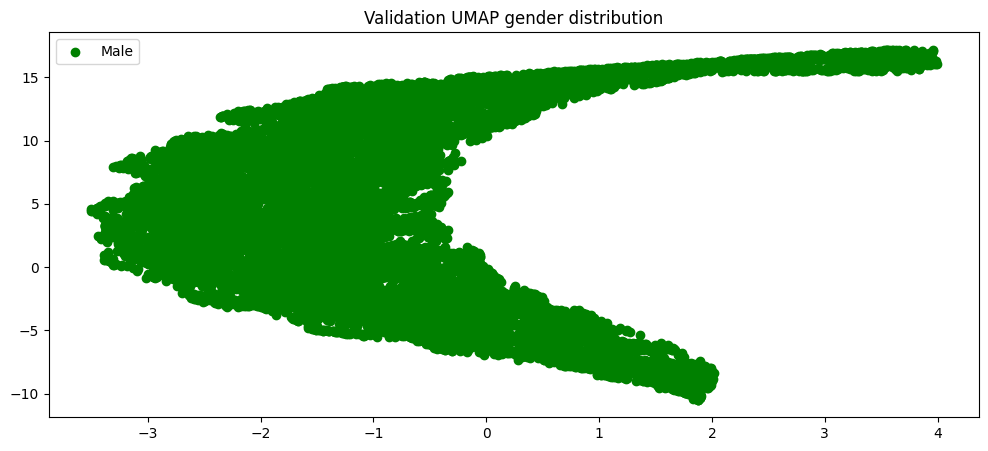

In [44]:
plt.figure(figsize=(12,5))
plt.title('Validation UMAP gender distribution')
plt.scatter(df_p[df_p['dim1'] < 4]['dim1'], df_p[df_p['dim1'] < 4]['dim2'], label = 'Male', color='green')
# plt.scatter(df_p[df_p['Gender'] == 'Female']['dim1'], df_p[df_p['Gender'] == 'Female']['dim2'], label = 'Female', color='red')

plt.legend()
plt.show()

In [90]:
df_p[df_p['dim1']<4].to_csv('less4umap.csv')

In [91]:
df_p[df_p['dim1']>4].to_csv('greater4umap.csv')